In [1]:
# general purpose python
import collections
import datetime
import glob
import hashlib
import importlib
import itertools
import json
import math
import os
import pickle
import random
import re
import shutil
import sys
import time
import warnings

# general purpose data science
import IPython
import ipywidgets as ipw
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly
import plotly.express as px
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs
import pylab
import scipy
import seaborn as sns
import sklearn
from sklearn import *
import statsmodels as sm

# computer vision
import cv2
import imageio
import PIL
from PIL import *

# deep learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('pytorch device:    ', device)

# geospatial
import rasterio as rio
import rasterio.features

ignore_warnings = True
if ignore_warnings:
    warnings.filterwarnings('ignore')
print('ignore warnings:   ', ignore_warnings)

seed = 1337
np.random.seed(seed)
torch.manual_seed(seed)
print('random seed:       ', seed)

mpl.rcParams['figure.dpi'] = 200

IPython.core.display.display(IPython.core.display.HTML("<style>.container { width:100% !important; }</style>"))

pd.options.display.max_colwidth = 32
pd.options.display.float_format = '{:,.6f}'.format
pd.options.display.expand_frame_repr = False

%matplotlib inline

sns.set(font_scale=1.3)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('muted'))

plotly.offline.init_notebook_mode(connected=True)
plotly.io.templates.default = 'plotly_white'

_ = torch.autograd.set_detect_anomaly(False)

pytorch device:     cuda
ignore warnings:    True
random seed:        1337


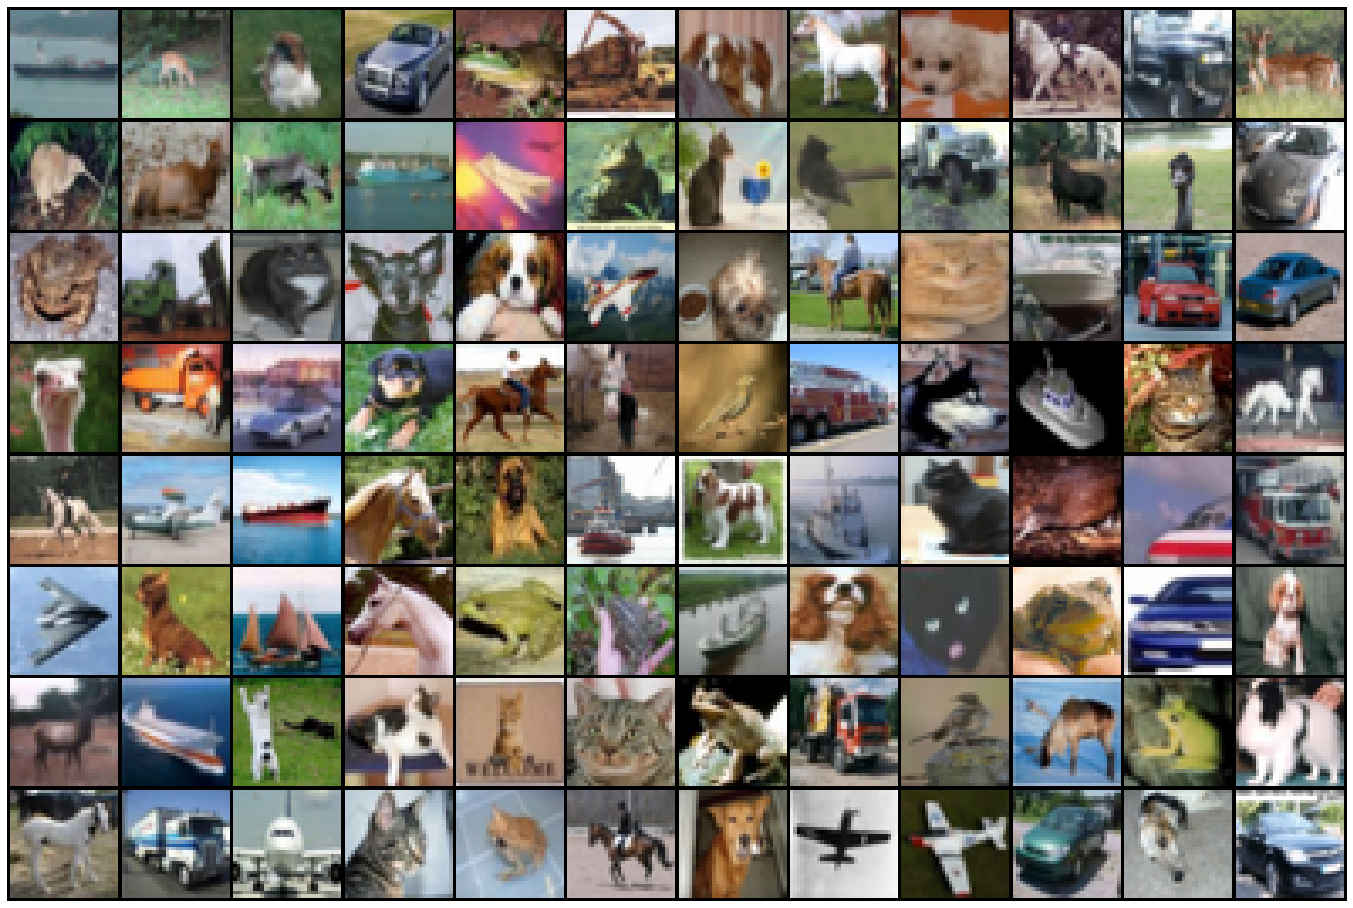

In [9]:
# create data loader
def get_data_loader(train, batch_size):
    img_transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            (0.5, 0.5, 0.5),
            (0.5, 0.5, 0.5))])
    dataset = torchvision.datasets.CIFAR10(
        root='/media/ntfs/data/torchvision_root',
        train=train,
        transform=img_transform)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=16,
        pin_memory=True)
    
    return data_loader

train_loader = get_data_loader(train=True,
                               batch_size=128)
test_loader = get_data_loader(train=False,
                               batch_size=128)

classes = (
    'plane',
    'car',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck')

# take a look at some samples
batch = next(iter(train_loader))

plt.figure(figsize=(24,24))
plt.imshow(
    np.transpose(
        torchvision.utils.make_grid(
            batch[0][:8*12],
            nrow=12,
            padding=1,
            normalize=True),(1,2,0)))
plt.axis('off')
plt.show()

In [4]:
# for debugging module size issues
class PrintShape(nn.Module):
    def __init__(self, label):
        super(PrintShape, self).__init__()
        self.label = label

    def forward(self, x):
        print(self.label, x.shape)
        return x


class ConvClassifier(nn.Module):
    def __init__(self,
                 n_output_dim=2,
                 n_conv_layers=2,
                 n_feature_maps=16,
                 feature_map_multiplier=2,
                 n_dense_layers=2,
                 n_dense_neurons=64,
                 dropout=0.0,
                 n_input_channels=3,
                 relu_slope=0.01,
                 bias=False):
        super(ConvClassifier, self).__init__()
        
        self.n_output_dim = n_output_dim
        self.n_feature_maps = n_feature_maps
        self.feature_map_multiplier = feature_map_multiplier
        self.n_dense_layers = n_dense_layers
        self.n_dense_neurons = n_dense_neurons
        self.dropout = dropout
        self.n_input_channels = n_input_channels
        self.relu_slope = relu_slope
        self.bias = bias
        
        modules = [
            nn.Conv2d(in_channels=self.n_input_channels,
                      out_channels=self.n_feature_maps,
                      kernel_size=5,
                      stride=1,
                      padding=2,
                      bias=False),
            nn.BatchNorm2d(num_features=self.n_feature_maps),
            nn.LeakyReLU(negative_slope=self.relu_slope,
                         inplace=True),
            nn.Conv2d(in_channels=self.n_feature_maps,
                      out_channels=self.n_feature_maps,
                      kernel_size=2,
                      stride=2,
                      padding=0,
                      bias=False),
            nn.BatchNorm2d(num_features=self.n_feature_maps),
            nn.LeakyReLU(negative_slope=self.relu_slope,
                         inplace=True)]
                        
        n_fm = self.n_feature_maps
        for i in range(n_conv_layers-1):
            modules.append(
                nn.Conv2d(
                    in_channels=n_fm,
                    out_channels=n_fm * self.feature_map_multiplier,
                    kernel_size=5,
                    stride=1,
                    padding=2,
                    bias=False))
            modules.append(
                nn.BatchNorm2d(
                    num_features=n_fm * self.feature_map_multiplier))
            modules.append(
                nn.LeakyReLU(
                    negative_slope=self.relu_slope,
                    inplace=True))
            modules.append(
                nn.Conv2d(in_channels=n_fm * self.feature_map_multiplier,
                          out_channels=n_fm * self.feature_map_multiplier,
                          kernel_size=2,
                          stride=2,
                          padding=0,
                          bias=False))
            modules.append(
                nn.BatchNorm2d(num_features=n_fm * self.feature_map_multiplier))
            modules.append(
                nn.LeakyReLU(negative_slope=self.relu_slope,
                             inplace=True))
            n_fm *= self.feature_map_multiplier
        
        modules.append(nn.Flatten())
        
        modules.append(
            nn.Linear(
                in_features=int((32/(2**n_conv_layers))**2 * n_fm),
                out_features=n_output_dim if self.n_dense_layers == 0 else self.n_dense_neurons,
                bias=self.bias))
        
        if self.n_dense_layers > 0:
            for i in range(self.n_dense_layers - 1):
                modules.append(
                    nn.LeakyReLU(
                        negative_slope=self.relu_slope,
                        inplace=True))
                modules.append(
                    nn.Dropout(
                        self.dropout))
                modules.append(
                    nn.Linear(
                        in_features=self.n_dense_neurons,
                        out_features=self.n_dense_neurons,
                        bias=self.bias))
            modules.append(
                nn.LeakyReLU(
                    negative_slope=self.relu_slope,
                    inplace=True))
            modules.append(
                nn.Dropout(
                    self.dropout))
            modules.append(
                nn.Linear(
                    in_features=self.n_dense_neurons,
                    out_features=self.n_output_dim,
                    bias=self.bias))
        
        modules = collections.OrderedDict(zip([f'layer_{i:03d}' for i in range(len(modules))], modules))
        self.main = nn.Sequential(modules)

    def forward(self, x):
        y = self.main(x)
        return y

    def get_hyperparams(self):
        hyperparams = collections.OrderedDict()
        hyperparams['n_output_dim'] = self.n_output_dim
        hyperparams['n_conv_layers'] = self.n_feature_maps
        hyperparams['n_feature_maps'] = self.n_feature_maps
        hyperparams['feature_map_multiplier'] = self.feature_map_multiplier
        hyperparams['n_dense_layers'] = self.n_dense_layers
        hyperparams['n_dense_neurons'] = self.n_dense_neurons
        hyperparams['dropout'] = self.dropout
        hyperparams['n_input_channels'] = self.n_input_channels
        hyperparams['relu_slope'] = self.relu_slope
        hyperparams['bias'] = self.bias
        return hyperparams


# create an instance
m = ConvClassifier(
    n_output_dim=10,
    n_conv_layers=2,
    n_feature_maps=32,
    feature_map_multiplier=1,
    n_dense_layers=3,
    n_dense_neurons=64,
    dropout=0.5,
    n_input_channels=3,
    relu_slope=0.1,
    bias=False).to(device)
print(m)
print(m.get_hyperparams())

# make sure that the input/output sizes are correct
x = torch.rand(128 * 3 * 32 * 32, device=torch.device('cuda')).view(128, 3, 32, 32)
print('input shape:  ', x.shape)
y = m.forward(x)
print('output shape: ', y.shape)
print(y.dtype)

ConvClassifier(
  (main): Sequential(
    (layer_000): Conv2d(3, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (layer_001): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_002): LeakyReLU(negative_slope=0.1, inplace=True)
    (layer_003): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (layer_004): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_005): LeakyReLU(negative_slope=0.1, inplace=True)
    (layer_006): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2), bias=False)
    (layer_007): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_008): LeakyReLU(negative_slope=0.1, inplace=True)
    (layer_009): Conv2d(32, 32, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (layer_010): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer_011): LeakyReLU(negative_slope=0.

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        modules = [
            nn.Conv2d(3, 16, 5),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            
            nn.Conv2d(16, 16, 2, 2),
            nn.BatchNorm2d(16),
            nn.LeakyReLU(),
            
            nn.Conv2d(16, 32, 5),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Conv2d(32, 32, 2, 2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            
            nn.Flatten(),
            
            nn.Linear(32 * 5 * 5, 128),
            nn.LeakyReLU(),
                        
            nn.Linear(128, 128),
            nn.LeakyReLU(),
            
            nn.Linear(128, 10)]
        modules = collections.OrderedDict(zip([f'layer_{i:03d}' for i in range(len(modules))], modules))
        self.main = nn.Sequential(modules)

    def forward(self, x):
        return self.main(x)
    
    def get_hyperparams(self):
        return collections.OrderedDict()

In [5]:
def evaluate_model(
    batch_size,
    n_output_dim,
    n_conv_layers,
    n_feature_maps,
    feature_map_multiplier,
    n_dense_layers,
    n_dense_neurons,
    dropout,
    n_input_channels,
    relu_slope,
    bias,
    n_epochs,
    learning_rate,
    weight_decay):
    
    model = ConvClassifier(
        n_output_dim=n_output_dim,
        n_conv_layers=n_conv_layers,
        n_feature_maps=n_feature_maps,
        feature_map_multiplier=feature_map_multiplier,
        n_dense_layers=n_dense_layers,
        n_dense_neurons=n_dense_neurons,
        dropout=dropout,
        n_input_channels=n_input_channels,
        relu_slope=relu_slope,
        bias=bias).to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=learning_rate,
        weight_decay=weight_decay,
        betas=(0.5, 0.999))
    
    train_loader = get_data_loader(train=True,
                                  batch_size=batch_size)
    test_loader = get_data_loader(train=False,
                                  batch_size=batch_size)

    train_loss_history = []
    test_loss_history = []
    start_ts = datetime.datetime.now()
    print(start_ts.strftime('%H:%M:%S'))
    for epoch in range(1, n_epochs + 1):
        train_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            for param in model.parameters():
                param.grad = None
            x, y_true = data
            x = x.to(device)
            y_true = y_true.to(device)
            y_pred = model(x)
            loss = criterion(y_pred, y_true)
            train_loss += loss
            loss.backward()
            optimizer.step()
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
            
        test_loss = 0.0
        for i, data in enumerate(test_loader, 0):
            with torch.no_grad():
                x, y_true = data
                x = x.to(device)
                y_true = y_true.to(device)
                y_pred = model(x)
                loss = criterion(y_pred, y_true)
                test_loss += loss
        test_loss /= len(test_loader)
        test_loss_history.append(test_loss)
            
        print('{1}{0}epoch: {2:03d}/{3:03d}{0}batch: {4:05d}/{5:05d}{0}train loss: {6:0.4f}{0}test loss: {7:0.4f}'.format(
                    '        ',
                    datetime.datetime.now().strftime('%H:%M:%S'),
                    epoch,
                    n_epochs,
                    i,
                    len(train_loader),
                    train_loss,
                    test_loss))
    
    last_train_loss = train_loss_history[-1]
    min_train_loss = min(train_loss_history)
    last_test_loss = test_loss_history[-1]
    min_test_loss = min(test_loss_history)
    
    training_time = int((datetime.datetime.now() - start_ts).total_seconds())

    results = model.get_hyperparams()
    results['batch_size'] = batch_size
    results['n_epochs'] = n_epochs
    results['learning_rate'] = learning_rate
    
    file_name = f'img_classif_hyperparam_opt_result_{hashlib.sha1(str(results).encode("utf-8")).hexdigest()[:8]}.json'
#     print(file_name)
    
    results['last_train_loss'] = round(last_train_loss.item(), 4)
    results['min_train_loss'] = round(min_train_loss.item(), 4)
    results['last_test_loss'] = round(last_test_loss.item(), 4)
    results['min_test_loss'] = round(min_test_loss.item(), 4)
    results['training_time'] = training_time
    
    with open(file_name, 'w') as f:
        f.write(json.dumps(results))
    
#     for k in results.keys():
#         print(f'{k:40}', results[k])
    
#     plt.figure(figsize=(10, 5))
#     x_scale = np.linspace(1, n_epochs, len(train_loss_history))
#     plt.plot(x_scale,
#              train_loss_history,
#              c='b',
#              linewidth=1,
#              marker='.',
#              label='Train loss')
#     plt.plot(x_scale,
#              test_loss_history,
#              c='r',
#              linewidth=1,
#              marker='.',
#              label='Test loss')
#     plt.xticks(range(0, n_epochs + 1))
#     plt.xlim(1, n_epochs)
#     plt.ylim(0, None)
#     plt.legend()
#     plt.show()


# evaluate_model(
#     batch_size=256,
#     n_output_dim=10,
#     n_conv_layers=2,
#     n_feature_maps=16,
#     feature_map_multiplier=2,
#     n_dense_layers=2,
#     n_dense_neurons=128,
#     dropout=0.0,
#     n_input_channels=3,
#     relu_slope=0.1,
#     bias=False,
#     n_epochs=2,
#     learning_rate=0.003,
#     weight_decay=1e-5)

In [6]:
for batch_size in [8, 64]:
    for learning_rate in [0.01, 0.001, 0.0001]:
        for n_conv_layers in [2, 3]:
            for n_feature_maps in [8, 32]:
                for feature_map_multiplier in [1, 2]:
                    for n_dense_layers in [0, 1, 2]:
                        for n_dense_neurons in [32, 128]:
                            evaluate_model(
                                batch_size=batch_size,
                                n_output_dim=10,
                                n_conv_layers=n_conv_layers,
                                n_feature_maps=n_feature_maps,
                                feature_map_multiplier=feature_map_multiplier,
                                n_dense_layers=n_dense_layers,
                                n_dense_neurons=n_dense_neurons,
                                dropout=0.0,
                                n_input_channels=3,
                                relu_slope=0.1,
                                bias=False,
                                n_epochs=10,
                                learning_rate=learning_rate,
                                weight_decay=1e-5)

21:49:20
21:49:33        epoch: 001/010        batch: 00624/03125        train loss: 49.5225        test loss: 2.8608
21:49:46        epoch: 002/010        batch: 00624/03125        train loss: 3.6642        test loss: 1.9434
21:49:59        epoch: 003/010        batch: 00624/03125        train loss: 192.4592        test loss: 10.1061
21:50:12        epoch: 004/010        batch: 00624/03125        train loss: 11.5459        test loss: 2.7195
21:50:25        epoch: 005/010        batch: 00624/03125        train loss: 5.2557        test loss: 2.1714
21:50:38        epoch: 006/010        batch: 00624/03125        train loss: 94.5802        test loss: 3.4326
21:50:51        epoch: 007/010        batch: 00624/03125        train loss: 5.6065        test loss: 2.4132
21:51:04        epoch: 008/010        batch: 00624/03125        train loss: 50.5253        test loss: 2.3898
21:51:17        epoch: 009/010        batch: 00624/03125        train loss: 16.0760        test loss: 2.2599
21:51:30   

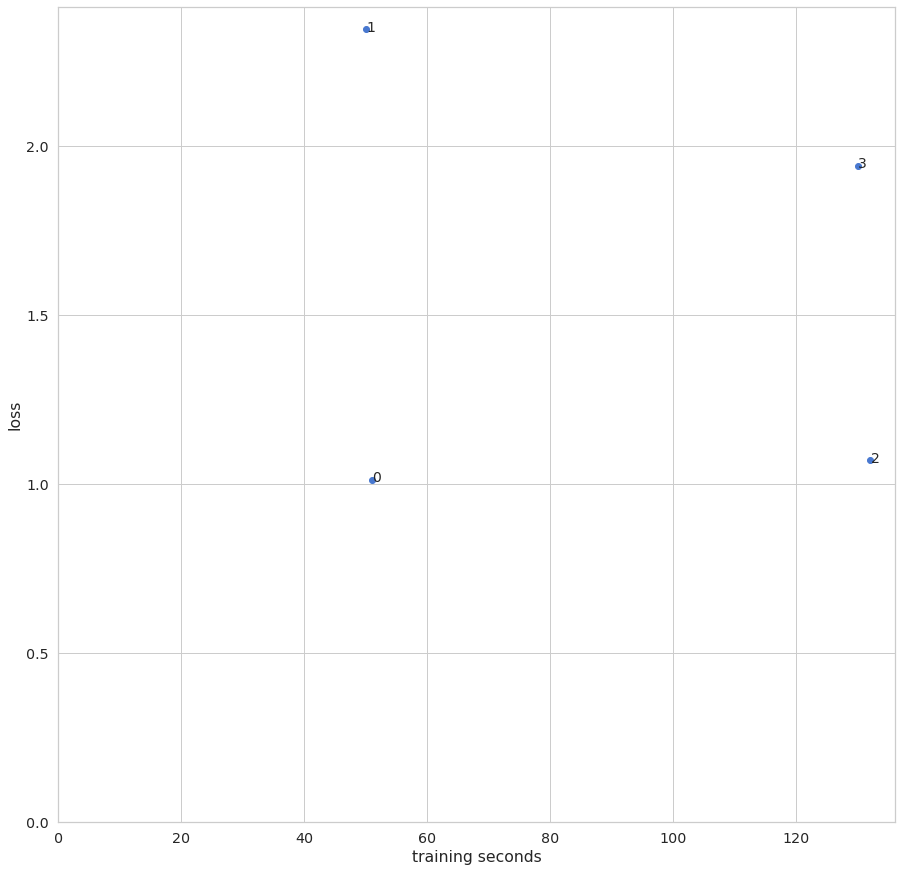

Loss order
   batch_size  n_conv_layers  n_f_maps  f_map_mul  n_dense_layers  n_dense_neurons  learning_rate  min_train_loss  min_test_loss  training_time  time_rank  loss_rank  comb_rank
0          64             16        16          2               2              128       0.010000        0.606600       1.013200             51          2          1          3
2          16             16        16          2               2              128       0.010000        1.048400       1.071300            132          4          2          6
3          16             16        16          2               2              128       0.030000        3.664200       1.943400            130          3          3          6
1          64             16        16          2               2              128       0.030000        1.827600       2.346400             50          1          4          5

Time order
   batch_size  n_conv_layers  n_f_maps  f_map_mul  n_dense_layers  n_dense_neurons  learning

In [7]:
performances = []
for file_name in glob.glob('img_classif_hyperparam_opt_result_*.json'):
    with open(file_name) as f:
        performances.append(json.loads(f.read()))
performances = pd.DataFrame(performances)[[
    'batch_size',
    'n_conv_layers',
    'n_feature_maps',
    'feature_map_multiplier',
    'n_dense_layers',
    'n_dense_neurons',
    'learning_rate',
    'min_train_loss',
    'min_test_loss',
    'training_time']]
performances.columns = [
    'batch_size',
    'n_conv_layers',
    'n_f_maps',
    'f_map_mul',
    'n_dense_layers',
    'n_dense_neurons',
    'learning_rate',
    'min_train_loss',
    'min_test_loss',
    'training_time']
performances['time_rank'] = performances.training_time.rank().astype(int)
performances['loss_rank'] = performances.min_test_loss.rank().astype(int)
performances['comb_rank'] = performances['time_rank'] + performances['loss_rank']
performances.sort_values(by=['comb_rank'], inplace=True)
performances.index = range(len(performances))

fig, ax = plt.subplots(figsize=(15, 15))
plt.scatter(
    performances.training_time,
    performances.min_test_loss)

for i in range(len(performances)):
    ax.annotate(
        str(i),
        (performances.training_time.tolist()[i] + 0.07, performances.min_test_loss.tolist()[i] - 0.006),
        fontsize=14)

plt.xlim((0, None))
plt.ylim((0, None))
plt.xlabel('training seconds')
plt.ylabel('loss')
plt.show()

print('Loss order')
print(performances.sort_values(by=['loss_rank']))
print()

print('Time order')
print(performances.sort_values(by=['time_rank']))
print()

print('Combined order')
print(performances.sort_values(by=['comb_rank']))